In [25]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from hyperopt import fmin, tpe, hp
import ipynb.fs.full.utils as utils
import ipynb.fs.full.features as features
import ipynb.fs.full.features_distancias as f_distancias



df_train = pd.read_csv('./data/train_filtrado.csv')
# Para usarse con el submit a Kaggle
df_eval = pd.read_csv('./data/test.csv')

df_train, df_eval = features.features_de_csvs(df_train, df_eval)

df_train_idf = pd.read_csv('./data/train_idf.csv')
df_eval_idf = pd.read_csv('./data/test_idf.csv')

df_train = pd.merge(df_train, df_train_idf, on= 'id', how= 'left')
df_eval = pd.merge(df_eval, df_eval_idf, on= 'id', how= 'left')

# Randoms solo para asegurarse que los features esten bien hechos
# df_train = df_train.sample(frac=1).reset_index(drop=True)
# df_train = utils.dolarizar_df(df_train)
# df_train = df_train.sample(frac=1).reset_index(drop=True)

df_train, df_test = utils.dividir_df_testeo(df_train, test_size=0.01)

df_test = features.llenar_nulls(df_test, hgb_mean=True, df_fill=df_train)
df_train = features.llenar_nulls(df_train, hgb_mean=True)


# df_train = df_train.sample(frac=1).reset_index(drop=True)
# df_test = utils.pesificar_df(df_test)
# df_train = df_train.sample(frac=1).reset_index(drop=True)


In [26]:
# df_train = df_train.sample(frac=1).reset_index(drop=True)

df_test_f = features.features_independientes_precio(df_test)
df_test_f = features.features_dependientes_precio(df_test_f, df_train)

df_train_f = features.features_independientes_precio(df_train)
df_train_f = features.features_dependientes_precio(df_train_f, df_train)

df_test_f, cols_tipodepropiedad_ohe = features.columna_a_ohe(df_test_f, 'tipodepropiedad', N=100, df_aux=df_train, devolver_cols=True)
df_test_f, cols_provincia_ohe = features.columna_a_ohe(df_test_f, 'provincia', N=100, df_aux=df_train, devolver_cols=True)
df_test_f, cols_zona_ohe = features.columna_a_ohe(df_test_f, 'zona', df_aux=df_train_f, devolver_cols=True)

df_train_f = features.columna_a_ohe(df_train_f, 'tipodepropiedad', N=100, df_aux=df_test)
df_train_f = features.columna_a_ohe(df_train_f, 'provincia', N=100, df_aux=df_test)
df_train_f = features.columna_a_ohe(df_train_f, 'zona', df_aux=df_test_f)


df_train_f['fecha'] = pd.to_datetime(df_train_f['fecha']).astype(int)
df_test_f['fecha'] = pd.to_datetime(df_test_f['fecha']).astype(int)

# df_train_f = df_train_f.sample(frac=1).reset_index(drop=True)

df_train_f = f_distancias.feature_distancias(df_train_f)
df_test_f = f_distancias.feature_distancias(df_test_f, df_train_f)

df_train_f = features.rankings(df_train_f, df_train_f)
df_test_f = features.rankings(df_test_f, df_train_f)

## Búsqueda hiperparámetros

### RandomizedSearchCV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV


features = ['antiguedad', 'habitaciones', 'garages', 'banos', 'metroscubiertos',
       'metrostotales', 'lat', 'lng', 'fecha', 'piscina', 'escuelascercanas',
       'centroscomercialescercanos', 'clustering_label', 'idf_titulo',
       'idf_descripcion', 'peso_titulo', 'peso_descripcion',
       'porcentaje_metros', 'diferencia_metros', 'metros_totales_normalizados',
       'metros_cubiertos_normalizados', 'escomercial',
       'promedio_metros_tipo_propiedad', 'promedio_metros_cub_tipo_propiedad',
       'prop_frecuente', 'top_provincia', 'es_ciudad_centrica',
       'promedio_metros_totales_provincia',
       'promedio_metros_cubiertos_provincia', 'mes', 'dia', 'trimestre',
       'dias_desde_datos', 'meses_desde_datos', 'antiguedad_bins_perc',
       'cantidad_inquilinos', 'tam_ambientes', 'promedio_precio_provincia',
       'promedio_precio_ciudad', 'varianza_precio_ciudad', 'count_ciudad',
       'promedio_id_zona', 'promedio_id_zona_gen', 'varianza_id_zona',
       'count_id_zona', 'promedio_precio_tipo_propiedad',
       'promedio_precio_tipo_propiedad_ciudad',
       'promedio_precio_tipo_propiedad_ciudad_gen', 'count_tipo_propiedad',
       'count_tipo_propiedad_ciudad', 'promedio_por_mes', 'varianza_por_mes',
       'promedio_precio_habitaciones',
       'promedio_precio_habitaciones_banos_garages',
       'promedio_precio_banos_garages', 'promedio_precio_hbg_tipo_propiedad',
       'lat_norm', 'lng_norm', 'promedio_precio_booleanos', 'puntaje',
       'distancia_ciudad_centrica', 'distancia_centro_mexico',
       'distancia_ciudad_cara']

lgb_params = {
    'boosting_type': ['gbdt'],
    'objective': ['regression'],
    'metric': ['mae'], # Si se deja vacio se toma el ideal para llegar al 'objective'
    'bagging_fraction': [0.1, 0.3, 0.5, 0.7, 0.9],
    'bagging_freq': [0, 1, 5, 10, 20, 40],
    'min_data_in_leaf': [10, 20, 40],
    'max_bin': [100, 175, 255],
    'reg_lambda': [0, 2, 6, 10],
    'min_split_gain': [0, 0.05, 0.1, 0.2],
    'feature_fraction': [0.85],
    'max_depth': [10],
    'num_leaves': [200],
    'learning_rate': [0.25],
    'n_jobs': [4]
}

x_train, x_test, y_train, y_test = utils.dividir_dataset(df_train_f, 'precio', features, test_size=1)

rs_cv = RandomizedSearchCV(estimator=lgb.LGBMRegressor(),
                           param_distributions=lgb_params, 
                           cv=3, 
                           n_iter=50,
                           verbose=3, scoring='neg_mean_absolute_error')

rs_cv.fit(x_train, y_train, verbose=1)

In [ ]:
display(rs_cv.best_params_)
from sklearn.externals import joblib
# Guarda el modelo
joblib.dump(gs_cv, 'lightgbm_rscv.pkl', compress=1)

In [ ]:
results = pd.DataFrame(rs_cv.cv_results_).sort_values('rank_test_score')

In [ ]:
results[['param_bagging_fraction',
'param_bagging_freq',
'param_min_data_in_leaf',
'param_bagging_freq',
'param_max_bin',
'param_reg_lambda',
'param_min_split_gain', 'mean_test_score', 'rank_test_score']].head(50)

### GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

features = ['antiguedad', 'habitaciones', 'garages', 'banos', 'metroscubiertos',
       'metrostotales', 'lat', 'lng', 'fecha', 'piscina', 'escuelascercanas',
       'centroscomercialescercanos', 'clustering_label', 'idf_titulo',
       'idf_descripcion', 'peso_titulo', 'peso_descripcion',
       'porcentaje_metros', 'diferencia_metros', 'metros_totales_normalizados',
       'metros_cubiertos_normalizados', 'escomercial',
       'promedio_metros_tipo_propiedad', 'promedio_metros_cub_tipo_propiedad',
       'prop_frecuente', 'top_provincia', 'es_ciudad_centrica',
       'promedio_metros_totales_provincia',
       'promedio_metros_cubiertos_provincia', 'mes', 'dia', 'trimestre',
       'dias_desde_datos', 'meses_desde_datos', 'antiguedad_bins_perc',
       'cantidad_inquilinos', 'tam_ambientes', 'promedio_precio_provincia',
       'promedio_precio_ciudad', 'varianza_precio_ciudad', 'count_ciudad',
       'promedio_id_zona', 'promedio_id_zona_gen', 'varianza_id_zona',
       'count_id_zona', 'promedio_precio_tipo_propiedad',
       'promedio_precio_tipo_propiedad_ciudad',
       'promedio_precio_tipo_propiedad_ciudad_gen', 'count_tipo_propiedad',
       'count_tipo_propiedad_ciudad', 'promedio_por_mes', 'varianza_por_mes',
       'promedio_precio_habitaciones',
       'promedio_precio_habitaciones_banos_garages',
       'promedio_precio_banos_garages', 'promedio_precio_hbg_tipo_propiedad',
       'lat_norm', 'lng_norm', 'promedio_precio_booleanos', 'puntaje',
       'distancia_ciudad_centrica', 'distancia_centro_mexico',
       'distancia_ciudad_cara']

# lgb_params = {
#     'boosting_type': ['gbdt'],
#     'objective': ['regression'],
#     'metric': ['mae'], # Si se deja vacio se toma el ideal para llegar al 'objective'
#     'bagging_fraction': [0.5, 0.7, 0.9],
#     'feature_fraction': [0.15, 0.35, 0.55, 0.65, 0.9],
#     'max_depth': [5, 10, 20],
#     'num_leaves': [15, 30, 45, 60, 100, 200],
#     'learning_rate': np.arange(0.05, 0.95, 0.2),
#     'n_jobs': [2]
# }

lgb_params = {
    'boosting_type': ['gbdt'],
    'objective': ['regression'],
    'metric': ['mae'], # Si se deja vacio se toma el ideal para llegar al 'objective'
    'bagging_fraction': [0.1, 0.3, 0.5, 0.7, 0.9],
    'bagging_freq': [0, 1, 5, 10, 20, 40],
    'feature_fraction': [0.9],
    'max_depth': [10],
    'num_leaves': [200],
    'learning_rate': [0.25],
    'n_jobs': [2]
}

x_train, x_test, y_train, y_test = utils.dividir_dataset(df_train_f, 'precio', features, test_size=1)

gs_cv = GridSearchCV(estimator=lgb.LGBMRegressor(), 
                           param_grid=lgb_params, 
                           cv=4,
                           verbose=1, scoring='neg_mean_absolute_error')

gs_cv.fit(x_train, y_train, verbose=1)

In [ ]:
display(gs_cv.best_params_)
from sklearn.externals import joblib
# Guarda el modelo
joblib.dump(gs_cv, 'lightgbm_gscv_4.pkl', compress=1)

In [ ]:
results = pd.DataFrame(gs_cv.cv_results_).sort_values('rank_test_score')

In [ ]:
results.head(5)

### hyperopt

In [ ]:
# features = ['habitaciones', 
#             'garages', 
#             'banos',
#             'antiguedad',
#             'metroscubiertos', 
#             'metrostotales', 
#             'lat', 'lng',
#             'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas', 'centroscomercialescercanos']

# features_test = ['prop_frecuente', 'top_provincia', 'promedio_precio_ciudad', 
#                  'anio', 'promedio_id_zona', 'promedio_precio_tipo_propiedad', 
#                  'count_id_zona', 'count_ciudad', 'puntaje', 
#                      'count_tipo_propiedad_ciudad', 
#                  'promedio_precio_tipo_propiedad_ciudad_gen',
#                  'count_id_zona'
#                  'dias_desde_datos',
#                  'meses_desde_datos',
#                  'porcentaje_metros',
#                  'promedio_precio_hbg_tipo_propiedad']

# features += features_test

# features += cols_tipodepropiedad_ohe + cols_provincia_ohe + cols_zona_ohe

features =['habitaciones', 
            'garages', 
            'banos',
            'antiguedad',
           'metroscubiertos', 
            'metrostotales',
            'lat_norm', 'lng_norm'
            'gimnasio', 'usosmultiples', 'piscina','prop_frecuente', 'top_provincia', 'promedio_precio_ciudad', 
                 'anio', 'promedio_id_zona', 'promedio_precio_tipo_propiedad', 
                 'count_id_zona', 'count_ciudad', 'puntaje', 
                     'count_tipo_propiedad_ciudad', 
                 'promedio_precio_tipo_propiedad_ciudad_gen',
                 'count_id_zona'
                 'dias_desde_datos',
                 'meses_desde_datos',
                 'porcentaje_metros',
                 'distancia_ciudad_centrica']

def eval_lightgbm(args):
    num_leaves, learning_rate, feature_fraction, bagging_fraction, bagging_freq, max_depth, test_size = args
    
    df_train_h = df_train_f.sample(frac=1).reset_index(drop=True)
    
    x_train, x_test, y_train, y_test = utils.dividir_dataset(df_train_h, 'precio', features, test_size=test_size)

    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)
    
    num_leaves = int(num_leaves)
    bagging_freq = int(bagging_freq)
    max_depth = int(max_depth)
    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': {'mae'}, # Si se deja vacio se toma el ideal para llegar al 'objective'
        'num_leaves': num_leaves,
        'learning_rate': learning_rate,
        'feature_fraction': feature_fraction,
        'bagging_fraction': bagging_fraction,
        'bagging_freq': bagging_freq,
        'max_depth': max_depth,
        'verbose': -1,
    }

    gbm = lgb.train(params,
                    lgb_train,
                    valid_sets=lgb_eval,
                    num_boost_round=150,
                    early_stopping_rounds=15,
                    verbose_eval=-1)
    
    y_pred_test = gbm.predict(utils.filtrar_features(df_test_f, features), num_iteration=gbm.best_iteration)
    return utils.MAE(df_test_f['precio'].values, y_pred_test)

space = [hp.quniform('num_leaves', 30, 180, 1), hp.uniform('learning_rate', 0.05, 0.9),
        hp.uniform('feature_fraction', 0.10, 0.90), hp.uniform('bagging_fraction', 0.10, 0.90),
        hp.quniform('bagging_freq', 1, 130, 1), hp.quniform('max_depth', 1, 30, 1),
        hp.uniform('test_size', 0.05, 0.25)]

hps = fmin(eval_lightgbm, space=space, algo=tpe.suggest, max_evals=200, verbose=1)

display(hps)

## Evaluación features

In [ ]:
#features = ['antiguedad', 'habitaciones', 'garages', 'banos',
#       'metroscubiertos', 'metrostotales', 
#            'lat', 'lng',
#       'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas', 'centroscomercialescercanos']

#features_test = ['prop_frecuente', 'top_provincia', 'porcentaje_metros', 'diferencia_metros', 'promedio_precio_ciudad', 
#                 'promedio_por_mes', 'anio', 'promedio_id_zona', 'promedio_precio_tipo_propiedad', 
#                 'promedio_precio_hbg_tipo_propiedad', 'count_id_zona', 'count_ciudad', 'puntaje', 
#                 'count_tipo_propiedad', 'count_tipo_propiedad_ciudad', 
                 'promedio_precio_tipo_propiedad_ciudad_gen', 'promedio_precio_hbg_tipo_propiedad_provincia',
                 'varianza_id_zona', 'promedio_id_zona_log', 'tam_ambientes', 'metros_cubiertos_normalizados', 
                 'dias_desde_datos', 'meses_desde_datos']

features += features_test

features += cols_tipodepropiedad_ohe + cols_provincia_ohe + cols_zona_ohe

features_remove = [['lat', 'lng'], ['antiguedad'], ['habitaciones'], ['garages'], ['banos'], ['metroscubiertos'], ['metrostotales'],
                   ['prop_frecuente'], ['top_provincia'], ['porcentaje_metros'], ['diferencia_metros'], 
                   ['promedio_precio_ciudad'],  ['promedio_por_mes'], ['anio'], ['promedio_id_zona'], ['promedio_id_zona_log'],
                   ['promedio_id_zona', 'promedio_id_zona_log'], ['promedio_precio_tipo_propiedad'],  
                   ['promedio_precio_hbg_tipo_propiedad'], ['count_id_zona'], ['count_ciudad'], 
                   ['puntaje'],  ['count_tipo_propiedad'], ['count_tipo_propiedad_ciudad'],  
                   ['promedio_precio_tipo_propiedad_ciudad_gen'], ['promedio_precio_hbg_tipo_propiedad_provincia'], 
                   ['varianza_id_zona'], ['tam_ambientes'], ['metros_cubiertos_normalizados'], ['dias_desde_datos'], 
                   ['meses_desde_datos']]

hps = {'bagging_fraction': 0.806451877022587,
 'bagging_freq': 62.0,
 'feature_fraction': 0.5379925983440028,
 'learning_rate': 0.1363027714646826,
 'max_depth': 11.0,
 'num_leaves': 113.0,
 'test_size': 0.09575190901892519}

bagging_fraction = hps['bagging_fraction']
bagging_freq = int(hps['bagging_freq'])
feature_fraction = hps['feature_fraction']
learning_rate = hps['learning_rate']
num_leaves = int(hps['num_leaves'])
max_depth = int(hps['max_depth'])
test_size = hps['test_size']

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'mae'}, # Si se deja vacio se toma el ideal para llegar al 'objective'
    'num_leaves': num_leaves,
    'learning_rate': learning_rate,
    'feature_fraction': feature_fraction,
    'bagging_fraction': bagging_fraction,
    'bagging_freq': bagging_freq,
    'max_depth': max_depth,
    'verbose': 0
}


base_train = 0
base_test = 0
base_eval = 0
for i in [['None']] + features_remove:
    
    features_new = [f for f in features if f not in i]
    if len(features_new) == len(features) and i != ['None']:
        print(f'{i} no encontrado')
        conitnue
    
    x_train, x_test, y_train, y_test = utils.dividir_dataset(df_train_f, 'precio', features_new, test_size=test_size)

    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

    gbm = lgb.train(params,
                    lgb_train,
                    valid_sets=lgb_eval,
                    num_boost_round=1000,
                    early_stopping_rounds=15,
                    verbose_eval=-1)

    y_pred_test = gbm.predict(x_test, raw_score=True, num_iteration=gbm.best_iteration)
    y_pred_train = gbm.predict(x_train, raw_score=True, num_iteration=gbm.best_iteration)
    y_pred_eval = gbm.predict(utils.filtrar_features(df_test_f, features_new), num_iteration=gbm.best_iteration)

    gbm_mae_train = utils.MAE(y_train, y_pred_train)
    gbm_mae = utils.MAE(y_test, y_pred_test)
    gbm_mae_eval = utils.MAE(df_test_f['precio'].values, y_pred_eval)

    print(f"MAE LightGBM (train): {gbm_mae_train:.5f}")
    print(f"MAE LightGBM (test): {gbm_mae:.5f}")
    print(f"MAE LightGBM (eval): {gbm_mae_eval:.5f}")
    if i != ['None']:
        print(f"Overfitting (base_eval - base_test) - (eval - test) - {i}: {(base_eval - base_test) - (gbm_mae_eval - gbm_mae)}")
        print(f"Diff evaluation (base_eval - eval)                  - {i}: {base_eval - gbm_mae_eval}")
        print(f"Diff train (base_train - train)                     - {i}: {base_train - gbm_mae_train}")
    else:
        base_train = gbm_mae_train
        base_test = gbm_mae
        base_eval = gbm_mae_eval

## Evaluación modelo final

/home/camix/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/camix/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:794: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


[1]	valid_0's l1: 1.29159e+06
Training until validation scores don't improve for 25 rounds
[2]	valid_0's l1: 1.06085e+06
[3]	valid_0's l1: 899297
[4]	valid_0's l1: 788203
[5]	valid_0's l1: 707457
[6]	valid_0's l1: 652811
[7]	valid_0's l1: 615866
[8]	valid_0's l1: 589992
[9]	valid_0's l1: 571220
[10]	valid_0's l1: 557145
[11]	valid_0's l1: 546245
[12]	valid_0's l1: 538419
[13]	valid_0's l1: 532962
[14]	valid_0's l1: 528316
[15]	valid_0's l1: 524706
[16]	valid_0's l1: 521971
[17]	valid_0's l1: 519042
[18]	valid_0's l1: 516525
[19]	valid_0's l1: 514420
[20]	valid_0's l1: 512856
[21]	valid_0's l1: 511293
[22]	valid_0's l1: 510103
[23]	valid_0's l1: 509369
[24]	valid_0's l1: 508383
[25]	valid_0's l1: 507232
[26]	valid_0's l1: 505966
[27]	valid_0's l1: 505434
[28]	valid_0's l1: 504783
[29]	valid_0's l1: 503655
[30]	valid_0's l1: 502817
[31]	valid_0's l1: 502048
[32]	valid_0's l1: 501288
[33]	valid_0's l1: 500311
[34]	valid_0's l1: 499779
[35]	valid_0's l1: 499229
[36]	valid_0's l1: 499314
[3

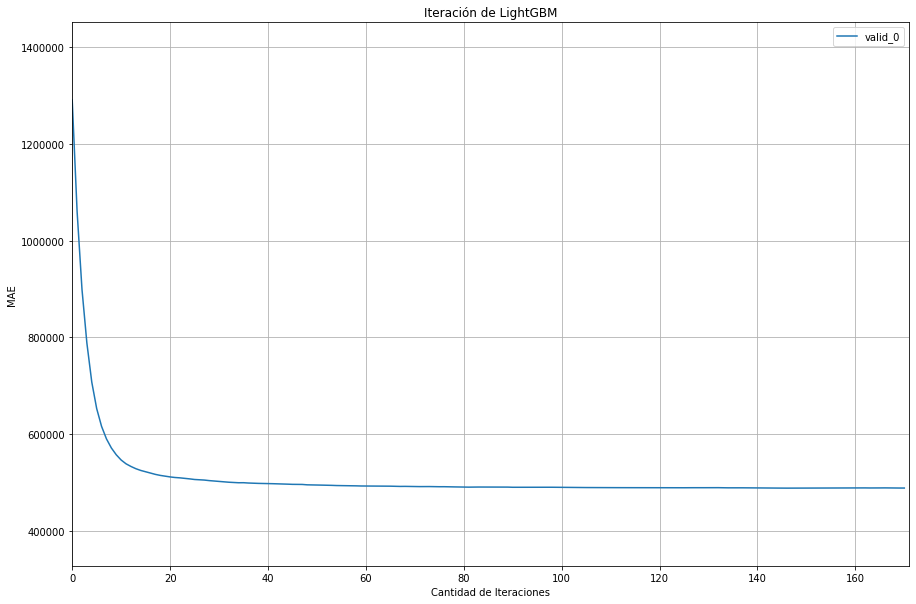

MAE LightGBM (train): 327465.37818
MAE LightGBM (test): 488068.26937
MAE LightGBM (eval): 511980.95356


In [27]:
import matplotlib.pylab as plt

features = ['antiguedad', 'habitaciones', 'garages', 'banos', 'metroscubiertos',
       'metrostotales', 'lat', 'lng', 'fecha', 'piscina',
       'clustering_label', 'idf_descripcion',
       'porcentaje_metros', 'diferencia_metros', 'promedio_metros_tipo_propiedad', 
       'prop_frecuente', 'top_provincia', 'es_ciudad_centrica',
       'mes', 'trimestre', 'dias_desde_datos',
       'tam_ambientes', 'promedio_precio_provincia',
       'promedio_precio_ciudad', 'count_ciudad',
       'promedio_id_zona', 'count_id_zona', 'promedio_precio_tipo_propiedad',
       'promedio_precio_tipo_propiedad_ciudad', 'count_tipo_propiedad',
       'count_tipo_propiedad_ciudad', 'promedio_por_mes',
       'promedio_precio_habitaciones_banos_garages',
       'promedio_precio_hbg_tipo_propiedad', 'puntaje',
       'distancia_ciudad_centrica', 'distancia_centro_mexico',
       'ranking_en_provincia_tipodepropiedad_precio',
       'ranking_en_provincia_tipodepropiedad_cantidad']

# params = {'bagging_fraction': 0.5,
#  'boosting_type': 'gbdt',
#  'feature_fraction': 0.9,
#  'learning_rate': 0.25,
#  'max_depth': 10,
#  'metric': 'mae',
#  'n_jobs': 2,
#  'num_leaves': 200,
#  'objective': 'regression'}
params = {'boosting_type': 'gbdt',
 'feature_fraction': 0.8,
 'learning_rate': 0.25,
 'max_bin': 255,
 'max_depth': 15,
 'metric': 'mae',
 'min_data_in_leaf': 40,
 'min_split_gain': 0.7,
 'n_jobs': 4,
 'num_leaves': 300,
 'objective': 'regression',
 'reg_lambda': 10,
 'verbose': -1,
 'n_estimators': 1500,
 'silent': True}


x_train, x_test, y_train, y_test = utils.dividir_dataset(df_train_f, 'precio', features, test_size=0.1)

lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)


evals_result = {}

gbm = lgb.train(params,
                lgb_train,
                valid_sets=lgb_eval,
                num_boost_round=500,
                early_stopping_rounds=25,
                evals_result=evals_result,
                verbose_eval=1)

print('Plotting metrics recorded during training...')
ax = lgb.plot_metric(evals_result,figsize=(15,10),xlabel = 'Cantidad de Iteraciones', ylabel = 'MAE', title = 'Iteración de LightGBM', grid = True)
plt.show()

# print('Plotting 54th tree...')  # one tree use categorical feature to split
# ax = lgb.plot_tree(gbm, tree_index=53, figsize=(15, 15), show_info=['split_gain'])
# plt.show()

# print('Plotting 54th tree with graphviz...')
# graph = lgb.create_tree_digraph(gbm, tree_index=53, name='Tree54')
# graph.render(view=True)

y_pred_test = gbm.predict(x_test, num_iteration=gbm.best_iteration)
y_pred_train = gbm.predict(x_train, num_iteration=gbm.best_iteration)

y_pred_eval = gbm.predict(utils.filtrar_features(df_test_f, features), num_iteration=gbm.best_iteration)

df_test_f['target'] = y_pred_eval
# df_test_f = utils.pesificar_df(df_test_f, 'target', 'target')

gbm_mae_train = utils.MAE(y_train, y_pred_train)
gbm_mae = utils.MAE(y_test, y_pred_test)
gbm_mae_eval = utils.MAE(df_test_f['precio'].values, df_test_f['target'].values)

print(f"MAE LightGBM (train): {gbm_mae_train:.5f}")
print(f"MAE LightGBM (test): {gbm_mae:.5f}")
print(f"MAE LightGBM (eval): {gbm_mae_eval:.5f}")

In [ ]:
import shap 
# shap.initjs()

df_test_shap = utils.filtrar_features(df_test_f, features)

explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(df_test_shap)

In [ ]:
# shap.force_plot(explainer.expected_value, shap_values, df_test_shap)

In [ ]:
shap.summary_plot(shap_values, df_test_shap)

## Evaluación df_test completo

In [ ]:
df_train = pd.read_csv('./data/train.csv',)

# Para usarse con el submit a Kaggle
df_test = pd.read_csv('./data/test.csv')

df_test = features.llenar_nulls(df_test, hgb_mean=True)
df_train = features.llenar_nulls(df_train, hgb_mean=True)

df_test_f = features.features_independientes_precio(df_test)
df_test_f = features.features_dependientes_precio(df_test_f, df_train)

df_train_f = features.features_independientes_precio(df_train)
df_train_f = features.features_dependientes_precio(df_train_f, df_train)

df_test_f, cols_tipodepropiedad_ohe = features.columna_a_ohe(df_test_f, 'tipodepropiedad', N=250, df_aux=df_train, devolver_cols=True)
df_test_f, cols_provincia_ohe = features.columna_a_ohe(df_test_f, 'provincia', N=250, df_aux=df_train, devolver_cols=True)
df_test_f, cols_zona_ohe = features.columna_a_ohe(df_test_f, 'zona', N=250, df_aux=df_train_f, devolver_cols=True)

df_train_f = features.columna_a_ohe(df_train_f, 'tipodepropiedad', N=250, df_aux=df_test)
df_train_f = features.columna_a_ohe(df_train_f, 'provincia', N=250, df_aux=df_test)
df_train_f = features.columna_a_ohe(df_train_f, 'zona', N=250, df_aux=df_test_f)

df_train_f = f_textos.features_textos(df_train_f)
df_test_f = f_textos.features_textos(df_test_f)

# df_train_f['fecha'] = pd.to_datetime(df_train_f['fecha']).astype(int)
# df_test_f['fecha'] = pd.to_datetime(df_test_f['fecha']).astype(int)


features =['antiguedad', 'garages', 'metroscubiertos', 'lng', 'fecha',
       'porcentaje_metros', 'dia', 'dias_desde_datos', 'tam_ambientes',
       'metros_totales_normalizados', 'varianza_precio_ciudad', 'count_ciudad',
       'promedio_id_zona', 'count_id_zona',
       'promedio_precio_tipo_propiedad_ciudad', 'count_tipo_propiedad_ciudad',
       'varianza_por_mes', 'promedio_precio_habitaciones_banos_garages',
       'lat_norm', 'puntaje', 'idf_titulo', 'idf_descripcion',
       'peso_descripcion', 'distancia_ciudad_centrica',
       'distancia_centro_mexico']

# hps = {'bagging_fraction': 0.806451877022587,
#  'bagging_freq': 62.0,
#  'feature_fraction': 0.5379925983440028,
#  'learning_rate': 0.1363027714646826,
#  'max_depth': 11.0,
#  'num_leaves': 113.0,
#  'test_size': 0.09575190901892519}


hps = {'bagging_fraction': 0.8988911725316586,
 'bagging_freq': 22.0,
 'feature_fraction': 0.6622442122619671,
 'learning_rate': 0.16422725363286422,
 'max_depth': 22.0,
 'num_leaves': 180.0,
 'test_size': 0.13892455926004772}


bagging_fraction = hps['bagging_fraction']
bagging_freq = int(hps['bagging_freq'])
feature_fraction = hps['feature_fraction']
learning_rate = hps['learning_rate']
num_leaves = int(hps['num_leaves'])
max_depth = int(hps['max_depth'])
test_size = hps['test_size']

params = {
    'boosting_type': 'dart',
    'objective': 'regression',
    'metric': {'mae'}, # Si se deja vacio se toma el ideal para llegar al 'objective'
    'num_leaves': num_leaves,
    'learning_rate': learning_rate,
    'feature_fraction': feature_fraction,
    'bagging_fraction': bagging_fraction,
    'bagging_freq': bagging_freq,
    'max_depth': max_depth,
    'verbose': 0
}

x_train, x_test, y_train, y_test = utils.dividir_dataset(df_train_f, 'precio', features, test_size=test_size)

lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)


gbm = lgb.train(params,
                lgb_train,
                valid_sets=lgb_eval,
                num_boost_round=1000,
                early_stopping_rounds=15,
                verbose_eval=1)

y_pred_test = gbm.predict(x_test, raw_score=True, num_iteration=gbm.best_iteration)
y_pred_train = gbm.predict(x_train, raw_score=True, num_iteration=gbm.best_iteration)
y_pred_eval = gbm.predict(utils.filtrar_features(df_test_f, features), num_iteration=gbm.best_iteration)

gbm_mae_train = utils.MAE(y_train, y_pred_train)
gbm_mae = utils.MAE(y_test, y_pred_test)

print(f"MAE LightGBM (train): {gbm_mae_train:.5f}")
print(f"MAE LightGBM (test): {gbm_mae:.5f}")

In [ ]:
y_pred_eval = gbm.predict(utils.filtrar_features(df_test_f, features), num_iteration=gbm.best_iteration)
df_test_f['target'] = y_pred_eval

# df_test_f = utils.pesificar_df(df_test_f, 'target', 'target')
df_test_f[['id', 'target']].to_csv('respuesta25.csv', index=False)

In [ ]:
utils.filtrar_features(df_test_f, features).columns.equals(x_train.columns)

In [ ]:
df_test_f.shape